In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import GetOldTweets3 as got
import random
import requests
import seaborn as sns
import sys

# # IBM personality insights
# from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
# from ibm_watson import PersonalityInsightsV3

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 30)

### Extracting past tweets from specified users.

In [ ]:
# encoding: utf-8

ideal_tweet_length = 500
ideal_spotify_songs_length = 20

data = pd.read_csv('input/context_content_features.csv',
                   error_bad_lines=False, warn_bad_lines=False, nrows=100000)

np.random.seed(5224)
# We randomly choose some users out.
idx = np.random.randint(data.user_id.unique(
).shape[0], size=data.user_id.unique().shape[0])

url = "https://tweeterid.com/ajax.php"


def get_twitter_username(user_id):
    payload = {'input': user_id}
    r = requests.post(url, payload)
    return r.text.replace('@', '')


def get_tweets(username):
    tweetCriteria = got.manager.TweetCriteria().setUsername(username).setSince(
        "2014-01-01").setUntil("2015-01-01").setMaxTweets(60)
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    tweet_concat = ""
    if len(tweets) > 0:
        for tweet in tweets:
            if len(tweet.text.strip().split()) >= ideal_tweet_length:
                continue
            tweet_concat += " " + tweet.text
    if len(tweet_concat.strip().split()) > ideal_tweet_length:
        return tweet_concat
    else:
        return 'error'


count = 0
fnames = ["user_id", "username", "tweets", "no_songs"]
final_df = pd.DataFrame([], columns=fnames)

for user_id in data.user_id.unique()[idx]:
    if count >= 150:
        break
    if data[data.user_id == user_id].shape[0] >= ideal_spotify_songs_length:
        twitter_username = get_twitter_username(user_id)
        if (twitter_username == 'error'):
            print('twitter_username error at: ' + str(user_id))
            continue
        print("Getting tweets for: " + twitter_username)
        twitter_tweets = get_tweets(twitter_username)
        if (twitter_tweets == 'error'):
            print('twitter_tweets error at: ' + str(user_id))
            continue
        print("Gotten data for: " + twitter_username)
        result_df = pd.DataFrame([[user_id, twitter_username, twitter_tweets,
                                   data[data.user_id == user_id].shape[0]]], columns=fnames)
        final_df = pd.concat([final_df, result_df])

        final_df.to_csv('output/pd.csv', encoding='utf-8', index=False)
        #writer.writerow({'user_id': user_id, 'username': twitter_username, 'tweets': twitter_tweets.encode(sys.stdout.encoding), 'no_songs': data[data.user_id == user_id].shape[0]})
        count = count + 1

#### Code to extract out personality insights from text content using IBM Personality Insights.

In [ ]:
# Note to developers: https://cloud.ibm.com/apidocs/personality-insights?code=python
# Refer to above URL for quick tutorial.

service = PersonalityInsightsV3(version="2017-10-13", authenticator=IAMAuthenticator(apikey="s4rthyqgEln0SKlun0Rt6yrA3UZiRxLM0dZCABLwKX4P"))
service.set_service_url("https://api.us-south.personality-insights.watson.cloud.ibm.com/instances/37ad4e3f-1761-4f5e-b63b-3d77cd8c3234")

data = pd.read_csv('pd_unique.csv', encoding='utf-8')

def parse_to_pi_format(row):
    return {'contentItems': [{'content': row.tweets}]}

with open('test.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # Just to write the header
    response = service.profile(parse_to_pi_format(data.loc[1,:]),accept='text/csv', csv_headers=True, raw_scores=True, consumption_preferences=True).get_result()
    writer.writerow(['user_id'] + list(csv.reader(response.content.decode('utf-8').splitlines()))[0])
    
    for index, row in data.iterrows():
        response = service.profile(parse_to_pi_format(row),accept='text/csv', csv_headers=True, raw_scores=True, consumption_preferences=True).get_result()
        profile = response.content
        cr = csv.reader(profile.decode('utf-8').splitlines())
        my_list = list(cr)
        for item in my_list[1:]:
            writer.writerow([row.user_id] + item)


### K-Means along with PCA and Scaling Pre-Processing Transformations

In [8]:
text_df = pd.read_csv('tweets.csv')
audio_df = pd.read_csv('spotify_features.csv')
ibm_df = pd.read_csv('personality_insights.csv')

# Quick check on shapes
print(f'We have {text_df.shape[0]} number of tweets.')
print(f'We have {audio_df.shape[0]} number of song data.')
print(f'We have {ibm_df.shape[0]} number of user scores.')

# We have 97 unique users who have at least a concatted length of >= 500 words.
# Idea of MAE and correlation tradeoff.
# https://cloud.ibm.com/docs/personality-insights?topic=personality-insights-input

We have 97 number of tweets.
We have 13351 number of song data.
We have 97 number of user scores.


In [63]:
# Interested qualities: big5 raw scores, consumption scores and user_id.
ibm_score_df = ibm_df.filter(regex='^consumption|big5\_[a-zA-Z]*\_raw|user_id',axis=1)
ibm_score_df

,user_id,big5_agreeableness_raw,big5_conscientiousness_raw,big5_extraversion_raw,big5_neuroticism_raw,big5_openness_raw,consumption_preferences_spur_of_moment,consumption_preferences_credit_card_payment,consumption_preferences_influence_brand_name,consumption_preferences_influence_utility,...,consumption_preferences_movie_action,consumption_preferences_movie_documentary,consumption_preferences_read_frequency,consumption_preferences_books_entertainment_magazines,consumption_preferences_books_non_fiction,consumption_preferences_books_financial_investing,consumption_preferences_books_autobiographies,consumption_preferences_volunteer,consumption_preferences_concerned_environment,consumption_preferences_start_business
0,1660016348,0.636463,0.549034,0.556837,0.668032,0.777299,0.0,1,0.0,1.0,...,0,1,0.0,0,1,1,1,0,1.0,1.0
1,774789176,0.725577,0.565932,0.585966,0.488021,0.756625,1.0,0,1.0,0.5,...,0,0,0.0,1,0,1,0,0,0.0,1.0
2,124640597,0.693068,0.650682,0.540111,0.694137,0.736176,0.0,1,1.0,0.5,...,1,1,0.0,0,0,1,0,0,0.5,0.5
3,946275781,0.761264,0.567339,0.609375,0.533985,0.798117,0.0,0,0.0,0.0,...,0,1,0.5,1,1,0,1,0,0.0,1.0
4,794756550,0.609791,0.564425,0.516165,0.673967,0.838892,0.0,1,0.0,1.0,...,1,1,1.0,0,1,1,1,0,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,17265787,0.695888,0.590312,0.533564,0.772852,0.838965,0.0,1,0.0,1.0,...,1,1,1.0,0,1,0,1,1,1.0,0.5
93,1629243692,0.728121,0.528538,0.625882,0.722927,0.756016,1.0,0,0.0,0.5,...,0,1,0.0,1,0,1,1,0,0.0,1.0
94,551291366,0.691540,0.533294,0.589840,0.569179,0.770045,1.0,0,0.0,1.0,...,0,1,0.0,1,1,0,1,0,0.0,1.0
95,1587472880,0.717560,0.595868,0.537940,0.488529,0.739153,1.0,1,0.0,1.0,...,0,1,0.0,1,0,0,1,0,0.0,0.0


In [71]:
# Checking if user_ids are all unique.
print(set(text_df["user_id"].values) == set(ibm_df["user_id"].values))
len(set(text_df["user_id"].values)) # We have 97 unique users exactly as expected.

True


97

In [67]:
df_train = pd.merge(text_df, ibm_score_df, on='user_id')
df_train

,user_id,username,tweets,no_songs,big5_agreeableness_raw,big5_conscientiousness_raw,big5_extraversion_raw,big5_neuroticism_raw,big5_openness_raw,consumption_preferences_spur_of_moment,...,consumption_preferences_movie_action,consumption_preferences_movie_documentary,consumption_preferences_read_frequency,consumption_preferences_books_entertainment_magazines,consumption_preferences_books_non_fiction,consumption_preferences_books_financial_investing,consumption_preferences_books_autobiographies,consumption_preferences_volunteer,consumption_preferences_concerned_environment,consumption_preferences_start_business
0,1660016348,abchitswebradio,#NOWPLAYING R.I.O. - U-Jean One In A Million ...,81,0.636463,0.549034,0.556837,0.668032,0.777299,0.0,...,0,1,0.0,0,1,1,1,0,1.0,1.0
1,774789176,GoFigureRadio,#NowPlaying Lil' Wayne - Bend It Over (f. 5th...,67,0.725577,0.565932,0.585966,0.488021,0.756625,1.0,...,0,0,0.0,1,0,1,0,0,0.0,1.0
2,124640597,djokaymegamixer,"@doyinokupe, can you please reel off your mas...",83,0.693068,0.650682,0.540111,0.694137,0.736176,0.0,...,1,1,0.0,0,0,1,0,0,0.5,0.5
3,946275781,t25cl,Billy Paul - Greatest Hits - War Of The Gods ...,286,0.761264,0.567339,0.609375,0.533985,0.798117,0.0,...,0,1,0.5,1,1,0,1,0,0.0,1.0
4,794756550,DeadAir_Radio,#NowPlaying DJ Kell Kill - Lasciva Nociva 12 ...,33,0.609791,0.564425,0.516165,0.673967,0.838892,0.0,...,1,1,1.0,0,1,1,1,0,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,17265787,SCIradio,Railroad Earth - 2007-03-31 - Irving Plaza - ...,31,0.695888,0.590312,0.533564,0.772852,0.838965,0.0,...,1,1,1.0,0,1,0,1,1,1.0,0.5
93,1629243692,ThePopsicle223,#NowPlaying http://thepopsicle223.com Selena ...,230,0.728121,0.528538,0.625882,0.722927,0.756016,1.0,...,0,1,0.0,1,0,1,1,0,0.0,1.0
94,551291366,ClassicRock105,COWBOY SONG - THIN LIZZY http://rdo.to/KTMCFM...,254,0.691540,0.533294,0.589840,0.569179,0.770045,1.0,...,0,1,0.0,1,1,0,1,0,0.0,1.0
95,1587472880,lavivafmnj,#NowPlaying - Viva Promo Navidad 1 la viva fm...,28,0.717560,0.595868,0.537940,0.488529,0.739153,1.0,...,0,1,0.0,1,0,0,1,0,0.0,0.0


In [95]:
audio_features = audio_df.columns[1:10]
audio_features # columns with song traits

Index(['instrumentalness', 'liveness', 'speechiness', 'danceability',
       'valence', 'loudness', 'tempo', 'acousticness', 'energy'],
      dtype='object')

In [107]:
audio_df_byuser = audio_df.groupby('user_id')[audio_features].mean()
audio_df_byuser # we aggregate the audio features for each unique user.

,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy
user_id,,,,,,,,,
14203234,0.553861,0.168698,0.048753,0.529517,0.315058,-10.383241,119.714480,0.365595,0.548360
16634031,0.007560,0.192902,0.135561,0.638401,0.538445,-7.039061,114.947377,0.158561,0.629296
17265787,0.577001,0.191571,0.052916,0.635774,0.670032,-12.477710,98.625806,0.684613,0.506065
17622174,0.440565,0.149714,0.048570,0.624571,0.513029,-10.337929,112.239661,0.491336,0.504745
17945688,0.161872,0.150503,0.079551,0.640020,0.575563,-8.786299,114.384746,0.291245,0.570562
19615058,0.061585,0.244685,0.065261,0.449208,0.419614,-7.538446,124.767485,0.079397,0.808564
20111329,0.000797,0.166272,0.032697,0.598444,0.539861,-5.405417,121.280111,0.101944,0.734111
22912624,0.125658,0.189652,0.051815,0.470148,0.499104,-7.247074,129.917630,0.175169,0.757519
23501043,0.256566,0.185885,0.104792,0.314381,0.295154,-6.589154,131.396115,0.008189,0.928923


In [112]:
print(set(df_train["user_id"].values) == set(audio_df_byuser.index.values)) 
# Verify that both dataframes have the same set of users before we proceed to inner join.
df_train = pd.merge(df_train, audio_df_byuser, left_on='user_id', right_index=True)

True


In [116]:
df_train.set_index('user_id', inplace=True)

In [240]:
df_train_num = df_train.iloc[:,3:]

In [580]:
df_train_num.reset_index(inplace=True)

In [582]:
df_train_num.to_csv("combined_df.csv")

### Feature selection based on variance explanation and correlation.

It makes sense for us to choose features which have good variance explanation, and are not too correlated with each other. We understand the context of the features through: https://cloud.ibm.com/docs/personality-insights?topic=personality-insights-preferences

We ultimately shortlist 10 features with highest perceived business domain value.

#### Consumption patterns for the music industry: We choose for our music consumption features.

We can extract the feature: `consumption_preferences_music_live__event`, since it has sufficient variance and also has good business value.

In [323]:
df_train_consume_music = df_train_num[df_train_num.columns[df_train_num.columns.str.startswith('consumption_preferences_music')]]

In [324]:
df_train_consume_music.shape

(97, 9)

In [315]:
df_train_consume_music.columns

Index(['consumption_preferences_music_rap',
       'consumption_preferences_music_country',
       'consumption_preferences_music_r_b',
       'consumption_preferences_music_hip_hop',
       'consumption_preferences_music_live_event',
       'consumption_preferences_music_playing',
       'consumption_preferences_music_latin',
       'consumption_preferences_music_rock',
       'consumption_preferences_music_classical'],
      dtype='object')

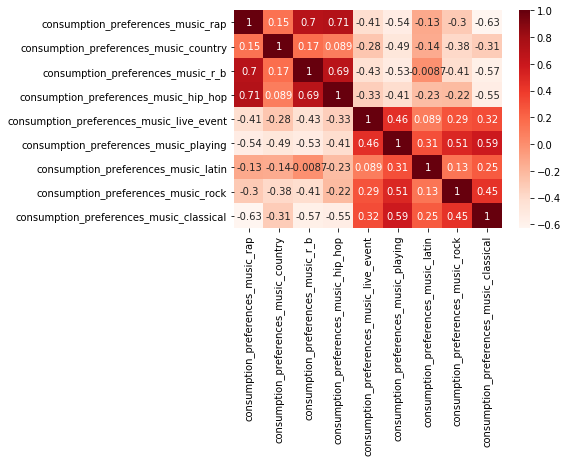

In [320]:
consume_cor = df_train_consume_music.corr()
sns.heatmap(consume_cor, annot = True, cmap = plt.cm.Reds)
plt.show()
# Note that we have 2 interesting diagonal blocks.

# VarianceThreshold selection.
from sklearn.feature_selection import VarianceThreshold
threshold_n = 0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
sel_var=sel.fit_transform(df_train_consume_music)
df_train_consume_music[df_train_consume_music.columns[sel.get_support(indices=True)]]

#### Consumption patterns for the reading industry: We choose for our reading consumption features.

We can extract the feature: `consumption_preferences_read_frequency`, choosing the most generic consumption feature for reading. -> likely to read often.

In [336]:
df_train_consume_read = df_train_num[df_train_num.columns[df_train_num.columns.str.startswith('consumption_preferences_read') | df_train_num.columns.str.startswith('consumption_preferences_books')]]

In [342]:
df_train_consume_read

# consume_cor = df_train_consume_read.corr()
# sns.heatmap(consume_cor, annot = True, cmap = plt.cm.Reds)
# plt.show()
# # Note that we have 2 interesting diagonal blocks.

# # VarianceThreshold selection.
from sklearn.feature_selection import VarianceThreshold
threshold_n = 0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
sel_var=sel.fit_transform(df_train_consume_read)
df_train_consume_read[df_train_consume_read.columns[sel.get_support(indices=True)]]

,consumption_preferences_read_frequency,consumption_preferences_books_entertainment_magazines,consumption_preferences_books_non_fiction,consumption_preferences_books_financial_investing,consumption_preferences_books_autobiographies
user_id,,,,,
1660016348,0.0,0,1,1,1
774789176,0.0,1,0,1,0
124640597,0.0,0,0,1,0
946275781,0.5,1,1,0,1
794756550,1.0,0,1,1,1
69058803,0.0,0,1,1,1
463215079,0.0,1,1,1,1
329923777,0.0,1,0,0,1
2185023655,0.0,1,0,1,0


#### Consumption patterns for the health industry: 

We can extract the feature: `consumption_preferences_eat_out` and `consumption_preferences_outdoor`, choosing the uncorrelated features.

In [343]:
df_train_consume_health = df_train_num[['consumption_preferences_eat_out', 'consumption_preferences_gym_membership', 'consumption_preferences_outdoor']]

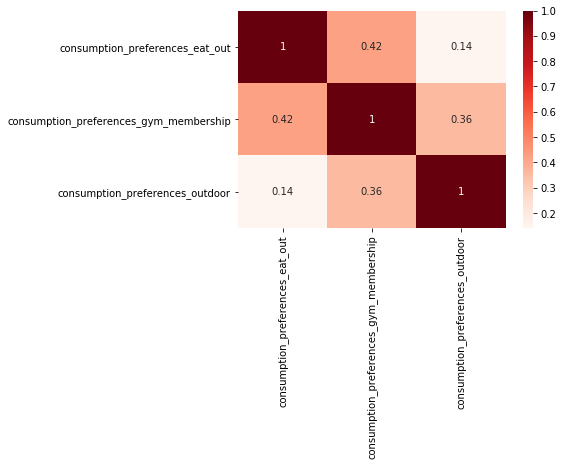

In [348]:
df_train_consume_health

consume_cor = df_train_consume_health.corr()
sns.heatmap(consume_cor, annot = True, cmap = plt.cm.Reds)
plt.show()


# # VarianceThreshold selection.
# from sklearn.feature_selection import VarianceThreshold
# threshold_n = 0.95
# sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
# sel_var=sel.fit_transform(df_train_consume_health)
# df_train_consume_health[df_train_consume_health.columns[sel.get_support(indices=True)]]

#### Consumption patterns for the environment, entrepeneurship and volunteering.

We can extract the features: `consumption_preferences_concerned_environemnt`, `consumption_preferences_volunteer`, `consumption_preferences_start_business`.

In [355]:
df_train_consume_env = df_train_num[['consumption_preferences_volunteer']]

In [356]:
df_train_consume_read

# consume_cor = df_train_consume_read.corr()
# sns.heatmap(consume_cor, annot = True, cmap = plt.cm.Reds)
# plt.show()
# # Note that we have 2 interesting diagonal blocks.

# # VarianceThreshold selection.
from sklearn.feature_selection import VarianceThreshold
threshold_n = 0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
sel_var=sel.fit_transform(df_train_consume_env)
df_train_consume_env[df_train_consume_env.columns[sel.get_support(indices=True)]]

,consumption_preferences_volunteer
user_id,
1660016348,0
774789176,0
124640597,0
946275781,0
794756550,0
69058803,0
463215079,0
329923777,0
2185023655,0


#### Consumption patterns for the advertisements.

We can extract the features: `consumption_preferences_influence_online_ads`.

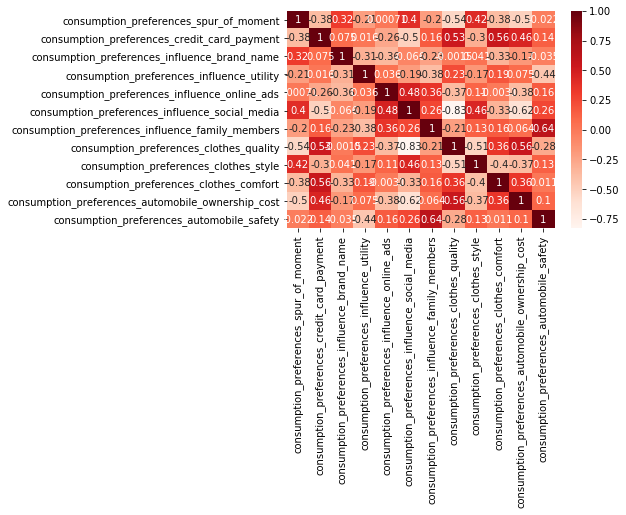

In [367]:
# df_train_consume_read

consume_cor = df_train_consume_shop.corr()
sns.heatmap(consume_cor, annot = True, cmap = plt.cm.Reds)
plt.show()
# Note that we have 2 interesting diagonal blocks.

# VarianceThreshold selection.
# from sklearn.feature_selection import VarianceThreshold
# threshold_n = 0.95
# sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
# sel_var=sel.fit_transform(df_train_consume_shop)
# df_train_consume_shop[df_train_consume_shop.columns[sel.get_support(indices=True)]].shape

#### Consumption patterns for the environment, entrepeneurship and volunteering.

We can extract the features: `consumption_preferences_concerned_environemnt`, `consumption_preferences_volunteer`, `consumption_preferences_start_business`.

In [355]:
df_train_consume_env = df_train_num[['consumption_preferences_volunteer']]

In [356]:
df_train_consume_read

# consume_cor = df_train_consume_read.corr()
# sns.heatmap(consume_cor, annot = True, cmap = plt.cm.Reds)
# plt.show()
# # Note that we have 2 interesting diagonal blocks.

# # VarianceThreshold selection.
from sklearn.feature_selection import VarianceThreshold
threshold_n = 0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
sel_var=sel.fit_transform(df_train_consume_env)
df_train_consume_env[df_train_consume_env.columns[sel.get_support(indices=True)]]

,consumption_preferences_volunteer
user_id,
1660016348,0
774789176,0
124640597,0
946275781,0
794756550,0
69058803,0
463215079,0
329923777,0
2185023655,0


In [374]:
df_train_noconsume

,big5_agreeableness_raw,big5_conscientiousness_raw,big5_extraversion_raw,big5_neuroticism_raw,big5_openness_raw,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy
user_id,,,,,,,,,,,,,,
1660016348,0.636463,0.549034,0.556837,0.668032,0.777299,0.000255,0.154352,0.060248,0.607235,0.426627,-5.118185,120.127691,0.362579,0.686185
774789176,0.725577,0.565932,0.585966,0.488021,0.756625,0.000046,0.221748,0.184497,0.683612,0.445260,-6.829060,121.525761,0.152484,0.622940
124640597,0.693068,0.650682,0.540111,0.694137,0.736176,0.014939,0.189739,0.083823,0.650145,0.579904,-6.809687,122.699000,0.157301,0.706325
946275781,0.761264,0.567339,0.609375,0.533985,0.798117,0.159725,0.165572,0.052989,0.573983,0.478684,-12.818217,114.885140,0.502228,0.419623
794756550,0.609791,0.564425,0.516165,0.673967,0.838892,0.364866,0.261042,0.050067,0.467727,0.300812,-8.632364,126.926030,0.145225,0.703036
69058803,0.637151,0.598711,0.491597,0.812980,0.787282,0.018657,0.261123,0.035984,0.426419,0.305390,-9.231968,123.805645,0.150980,0.630161
463215079,0.629986,0.578400,0.525403,0.437003,0.794997,0.326854,0.212512,0.042596,0.378625,0.357929,-9.918917,127.234792,0.081556,0.689583
329923777,0.694875,0.487154,0.545719,0.650199,0.740978,0.032292,0.151442,0.053328,0.552120,0.493504,-7.642940,116.583260,0.518289,0.559220
2185023655,0.724998,0.572781,0.617564,0.720672,0.800611,0.136337,0.145015,0.062750,0.564750,0.447780,-10.768250,123.657250,0.479915,0.480270


In [375]:
chosen_features = ['consumption_preferences_movie_horror', 'consumption_preferences_movie_action', 'consumption_preferences_influence_online_ads',
                  'consumption_preferences_credit_card_payment', 'consumption_preferences_read_frequency', 'consumption_preferences_gym_membership',
                  'consumption_preferences_outdoor', 'consumption_preferences_eat_out', 'consumption_preferences_start_business',
                  'consumption_preferences_concerned_environment']

In [380]:
df_train_consume = df_train_num[chosen_features]

In [381]:
df_train_consume
# consume_cor = df_train_consume.corr()
# sns.heatmap(consume_cor, annot = True, cmap = plt.cm.Reds)
# plt.show()

,consumption_preferences_movie_horror,consumption_preferences_movie_action,consumption_preferences_influence_online_ads,consumption_preferences_credit_card_payment,consumption_preferences_read_frequency,consumption_preferences_gym_membership,consumption_preferences_outdoor,consumption_preferences_eat_out,consumption_preferences_start_business,consumption_preferences_concerned_environment
user_id,,,,,,,,,,
1660016348,0,0,0,1,0.0,0,0.5,0.0,1.0,1.0
774789176,1,0,1,0,0.0,0,0.5,1.0,1.0,0.0
124640597,0,1,0,1,0.0,0,1.0,1.0,0.5,0.5
946275781,1,0,1,0,0.5,0,0.0,0.0,1.0,0.0
794756550,0,1,0,1,1.0,0,0.5,0.0,0.5,1.0
69058803,0,1,0,0,0.0,0,0.5,0.5,1.0,1.0
463215079,0,1,0,1,0.0,0,0.5,0.0,0.0,0.5
329923777,1,0,1,0,0.0,0,0.0,0.0,1.0,0.0
2185023655,1,0,0,0,0.0,0,0.5,1.0,1.0,0.0


In [383]:
df_train = pd.concat([df_train_consume, df_train_noconsume], axis = 1)

### We run K-Means with some heuristics to choose number of clusters.

In [555]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
# so far best one, maybe choose consume best.
# we can consider doing feature selection of consumption preferences.
# variance and correlation coefficients.

df_train_scaled = scaler.fit_transform(df_train_num.values)

In [556]:
df_train_scaled

array([[-1.916492  , -0.45757643, -0.02774711, ..., -0.10921477,
         1.08996415,  0.01900609],
       [ 0.48047514, -0.01788132,  0.60782411, ...,  0.05361784,
        -0.38367623, -0.54144877],
       [-0.39395492,  2.18736153, -0.39269925, ...,  0.19026448,
        -0.34988468,  0.19748101],
       ...,
       [-0.43505977, -0.86714328,  0.69234454, ...,  0.46140293,
        -0.50932182,  0.13570662],
       [ 0.26483175,  0.76105853, -0.4400641 , ...,  0.60397277,
         1.07981301, -0.3048197 ],
       [-0.16192109,  1.5549324 , -0.25358374, ...,  0.28686334,
        -0.50405026, -0.5601842 ]])

In [557]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train_scaled)
                for k in range(1, 11)]
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(df_train_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]

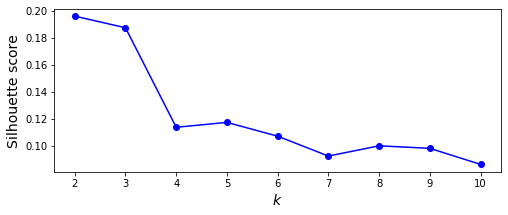

In [558]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
# save_fig("silhouette_score_vs_k_plot")
plt.show()

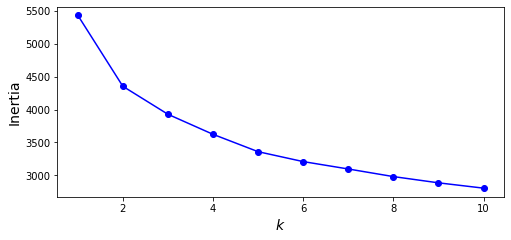

In [559]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

### We can see that the inertia and silhouette scores are not very good, and we can consider dimension reduction on our features to improve on our clustering heuristics.

#### Dimension Reduction Technique 1: PCA

In [583]:
df_train_scaled

array([[-1.916492  , -0.45757643, -0.02774711, ..., -0.10921477,
         1.08996415,  0.01900609],
       [ 0.48047514, -0.01788132,  0.60782411, ...,  0.05361784,
        -0.38367623, -0.54144877],
       [-0.39395492,  2.18736153, -0.39269925, ...,  0.19026448,
        -0.34988468,  0.19748101],
       ...,
       [-0.43505977, -0.86714328,  0.69234454, ...,  0.46140293,
        -0.50932182,  0.13570662],
       [ 0.26483175,  0.76105853, -0.4400641 , ...,  0.60397277,
         1.07981301, -0.3048197 ],
       [-0.16192109,  1.5549324 , -0.25358374, ...,  0.28686334,
        -0.50405026, -0.5601842 ]])

In [564]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(df_train_scaled)

In [565]:
pca.explained_variance_ratio_

array([0.25268207, 0.14299256])

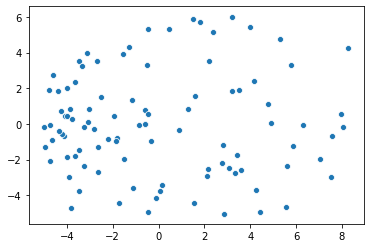

In [566]:
sns.scatterplot(pca_result[:,0], pca_result[:,1])

In [567]:
kmeans_per_k = [KMeans(n_clusters=k).fit(pca_result)
                for k in range(1, 11)]
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(pca_result, model.labels_)
                     for model in kmeans_per_k[1:]]

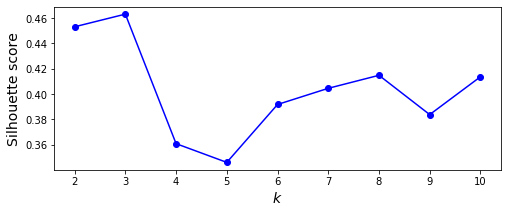

In [568]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
# save_fig("silhouette_score_vs_k_plot")
plt.show()

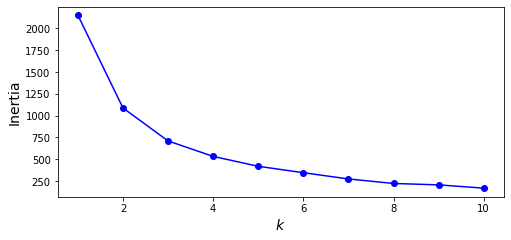

In [569]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

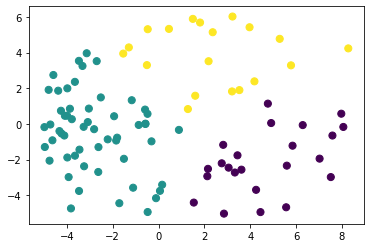

In [570]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(pca_result)
ymeans = kmeans.predict(pca_result)

plt.scatter(pca_result[:,0], pca_result[:,1], c=ymeans, s=50, cmap='viridis')

#### Dimension Reduction Technique 2: T-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 97 samples in 0.000s...
[t-SNE] Computed neighbors for 97 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 97 / 97
[t-SNE] Mean sigma: 4.030238
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.666748
[t-SNE] KL divergence after 300 iterations: 0.548462


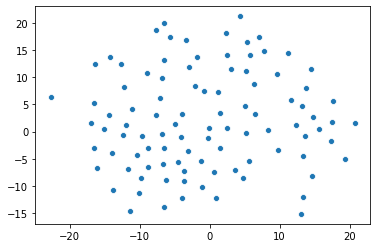

In [571]:
tsne = TSNE(n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(df_train_scaled)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1])

In [549]:
df_train_scaled[1].reshape(1,-1)

array([[ 0.76822128, -0.47733437,  1.05294618, -0.76822128, -0.52411131,
        -0.46097722,  0.45692524,  1.16497201,  0.68091764, -0.58375224,
         0.48047514, -0.01788132,  0.60782411, -0.94601526, -0.11425695,
        -0.78385691,  0.59352849,  2.64858927,  1.25639661, -0.4144522 ,
         0.41907032,  0.05361784, -0.38367623, -0.54144877]])

In [547]:
pca.transform(df_train_scaled[1].reshape(1,-1))

array([[-2.08496011, -1.48624655]])

In [572]:
kmeans_per_k = [KMeans(n_clusters=k).fit(tsne_results)
                for k in range(1, 11)]
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(tsne_results, model.labels_)
                     for model in kmeans_per_k[1:]]

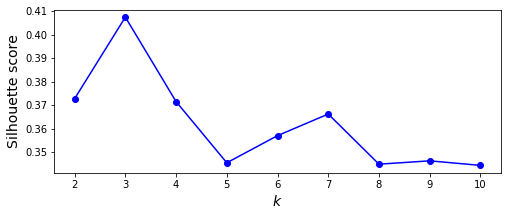

In [573]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
# save_fig("silhouette_score_vs_k_plot")
plt.show()

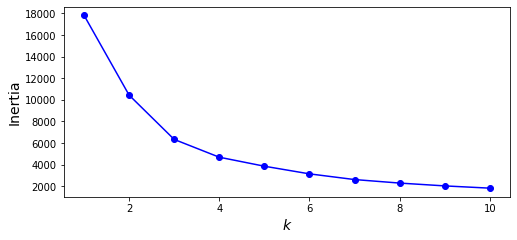

In [574]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

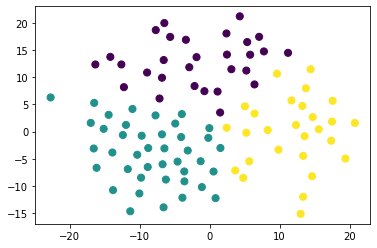

In [575]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tsne_results)
ymeans = kmeans.predict(tsne_results)

plt.scatter(tsne_results[:,0], tsne_results[:,1], c=ymeans, s=50, cmap='viridis')

##### Both agree that we should have 3 clusters as the optimal number of clusters. We should note that  

In [585]:
import requests
import json

In [584]:
url = 'https://dt4o8agm5c.execute-api.us-east-1.amazonaws.com/v1'

#### Making use of AWS API Gateway Endpoint

In [6]:
request2 = {
  "instances": [
    {
      "features": [
        [
          3.61531898,
          -2.56124051
        ]
      ]
    },
    {
  "features": [
    [
      3.61531898,
      -2.56124051
    ]
  ]
    }
    ,
    {
  "features": [
    [
      3.61531898,
      -2.56124051
    ]
  ]
    }
  ]
}



In [7]:
response = requests.post(url, data=json.dumps(request2))

In [8]:
result = response.json()

In [9]:
result

{'statusCode': 200,
 'isBase64Encoded': False,
 'body': {'predictions': [{'distance_to_cluster': 1.1137917041778564,
    'closest_cluster': 0.0},
   {'distance_to_cluster': 1.1137917041778564, 'closest_cluster': 0.0},
   {'distance_to_cluster': 1.1137917041778564, 'closest_cluster': 0.0}]}}